# Modeling

In [1]:
# module imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
# Importing necessary packages
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from scipy.sparse import hstack
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from scipy.stats import zscore
# Modelling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# Ensample learning
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# Cross validation for evaluation
from sklearn.model_selection import cross_val_score

In [2]:
# Loading our data into a dataframe
data = pd.read_csv('Restaurants.csv')
data.drop(['name', 'address', 'reviews_list', 'menu_item', 'cuisines', 'rest_type', 'location'], axis=1, inplace=True) 

In [3]:
X = data.drop(columns=['rate'])  # Features
y = data['rate']  # Target variable

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature engineering

#### **Features** are how data is presented to a model, serving to inform that model on things it may not infer by itself. 
#### Based on the principle Garbige in Garbige out Feature engineering will likely reap the highest accuracy gains in the modeling process than the selection of the algorithm itself.

### Feature Extraction

- Throughout our analysis encompassing `Data Preparation` and `Exploratory Data Analysis (EDA)`, we've adeptly crafted and extracted significant features to enrich our model's understanding, including:
  - `menu_variety`: Reflecting the diversity of menu items offered by each restaurant.
  - `duplicate_count`: A metric gauging the frequency of duplicate combinations we have removed, empowering the model to handle that if needed.
  - `has_menu`: A binary indicator signaling the availability of a menu at each restaurant.
  - `votes_bins`: Discretized representation of the 'Votes' feature, categorized into ['Low', 'Medium', 'High', 'Extreme', 'Supreme'] bins.
  - `cuisines_weights`: A feature quantifying the prevalence of that resturant cuisine that he offer across the entire market.
  - `rest_type_market_share`: A metric capturing the weighted popularity of various restaurant types in the market.

These meticulously engineered features not only enhance the richness of our dataset but also provide valuable insights for our model to make informed predictions.

### Feature Preprocessing

##### In the feature preprocessing phase, we meticulously prepare our dataset to optimize its compatibility with machine learning models. Given the inherent numerical nature of these models, it's imperative to convert all data into numerical representations.

- Numerical features undergo a process called scaling, where their values are adjusted to a standardized range. This ensures that features with larger magnitudes do not unduly influence the model's learning process.

- Categorical features, on the other hand, require encoding to transform them into a numerical format. 

By meticulously preparing our features through scaling for numerical data and encoding for categorical data, we optimize their interpretability by machine learning models, fostering accurate and reliable predictions.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   online_order                 12457 non-null  object 
 1   book_table                   12457 non-null  object 
 2   rate                         12457 non-null  float64
 3   votes                        12457 non-null  float64
 4   approx_cost(for two people)  12457 non-null  float64
 5   listed_in(type)              12457 non-null  object 
 6   listed_in(city)              12457 non-null  object 
 7   menu_variety                 12457 non-null  int64  
 8   duplicate_count              12457 non-null  int64  
 9   has_menu                     12457 non-null  int64  
 10  votes_bins                   12457 non-null  object 
 11  cuisines_weights             12457 non-null  float64
 12  rest_type_market_share       12457 non-null  float64
dtypes: float64(5), i

In [5]:
categorical_features_1 = data.select_dtypes('object').columns
numeric_features_1 = data.select_dtypes(include=['float64', 'int64']).columns
print("We have {} Numerical Features: {}".format(len(numeric_features_1), numeric_features_1))
print("We have {} Categorical Features: {}".format(len(categorical_features_1), categorical_features_1))

We have 8 Numerical Features: Index(['rate', 'votes', 'approx_cost(for two people)', 'menu_variety',
       'duplicate_count', 'has_menu', 'cuisines_weights',
       'rest_type_market_share'],
      dtype='object')
We have 5 Categorical Features: Index(['online_order', 'book_table', 'listed_in(type)', 'listed_in(city)',
       'votes_bins'],
      dtype='object')


In [6]:
data.head(5) 

,online_order,book_table,rate,votes,approx_cost(for two people),listed_in(type),listed_in(city),menu_variety,duplicate_count,has_menu,votes_bins,cuisines_weights,rest_type_market_share
0,No,No,3.4,7.0,200.0,Delivery,Bellandur,0,2,0,Low,240.0,40.386931
1,Yes,No,3.9,48.0,400.0,Delivery,BTM,0,9,0,Medium,1059.0,40.386931
2,No,No,3.7,0.0,700.0,Buffet,Electronic City,0,3,0,NoVotes,1792.0,17.981858
3,Yes,No,3.7,37.0,400.0,Cafes,Bannerghatta Road,145,3,1,Medium,1074.0,4.455326
4,Yes,No,3.7,0.0,100.0,Dine-out,Rajajinagar,16,1,1,NoVotes,612.0,40.386931


In [7]:
data['rate'].describe()

count    12457.000000
mean         3.633451
std          0.384038
min          1.800000
25%          3.400000
50%          3.700000
75%          3.833333
max          4.900000
Name: rate, dtype: float64

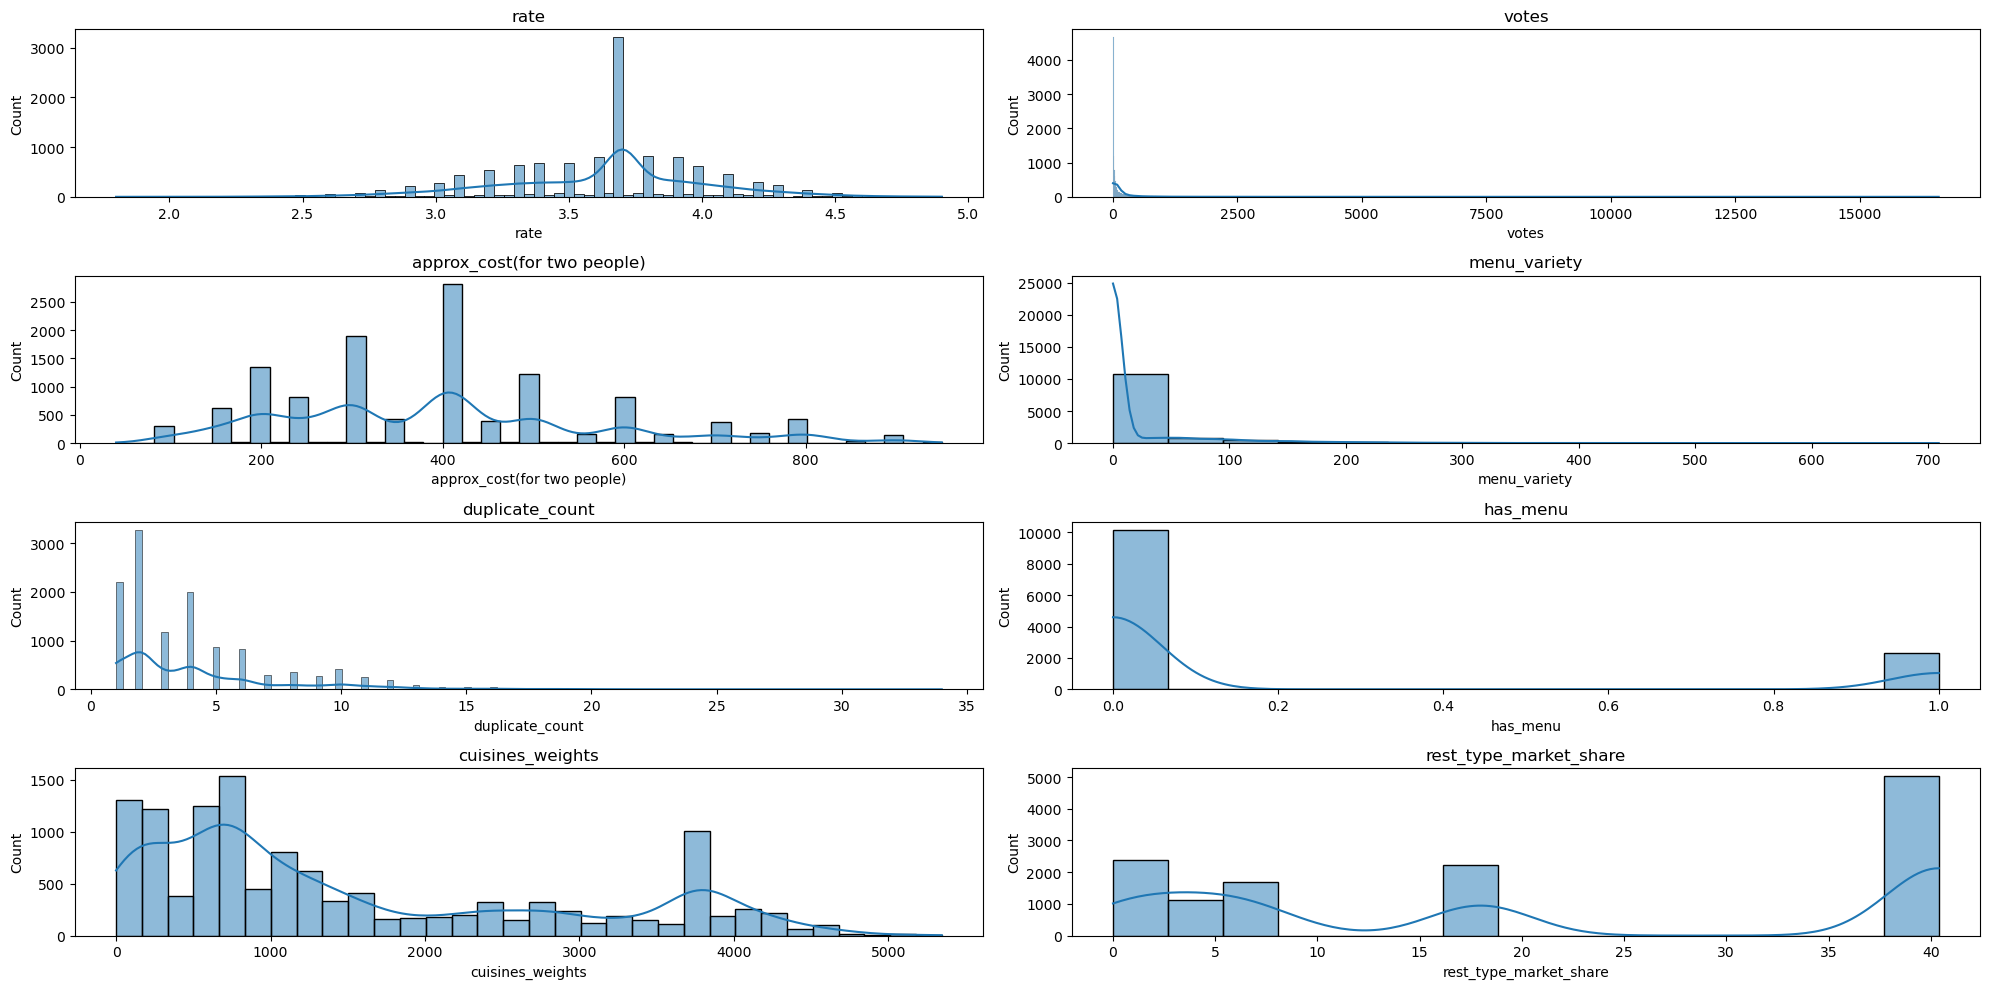

In [8]:
# Set figure size
plt.figure(figsize=(20, 10))

# Loop through each variable and create histogram with KDE
for i, var in enumerate(numeric_features_1):
    plt.subplot(4, 2, i+1)
    sns.histplot(data[var], kde=True)
    plt.title(var)

plt.tight_layout()
plt.show()

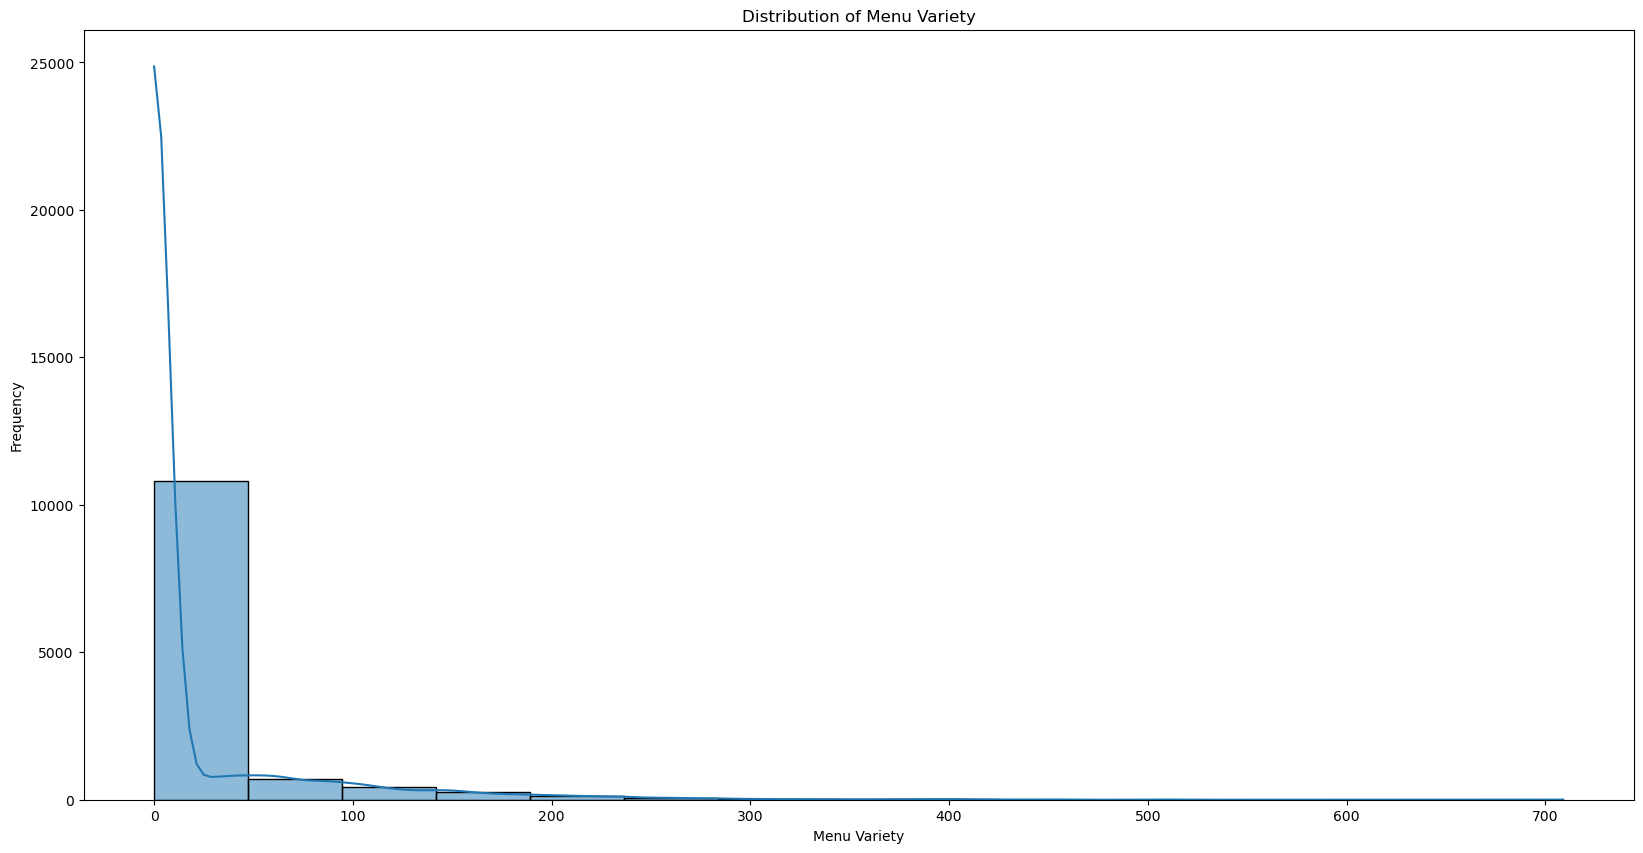

In [9]:
plt.figure(figsize=(20,10))
sns.histplot(data["menu_variety"], kde=True)
plt.xlabel('Menu Variety')
plt.ylabel('Frequency')
plt.title('Distribution of Menu Variety')
plt.show()

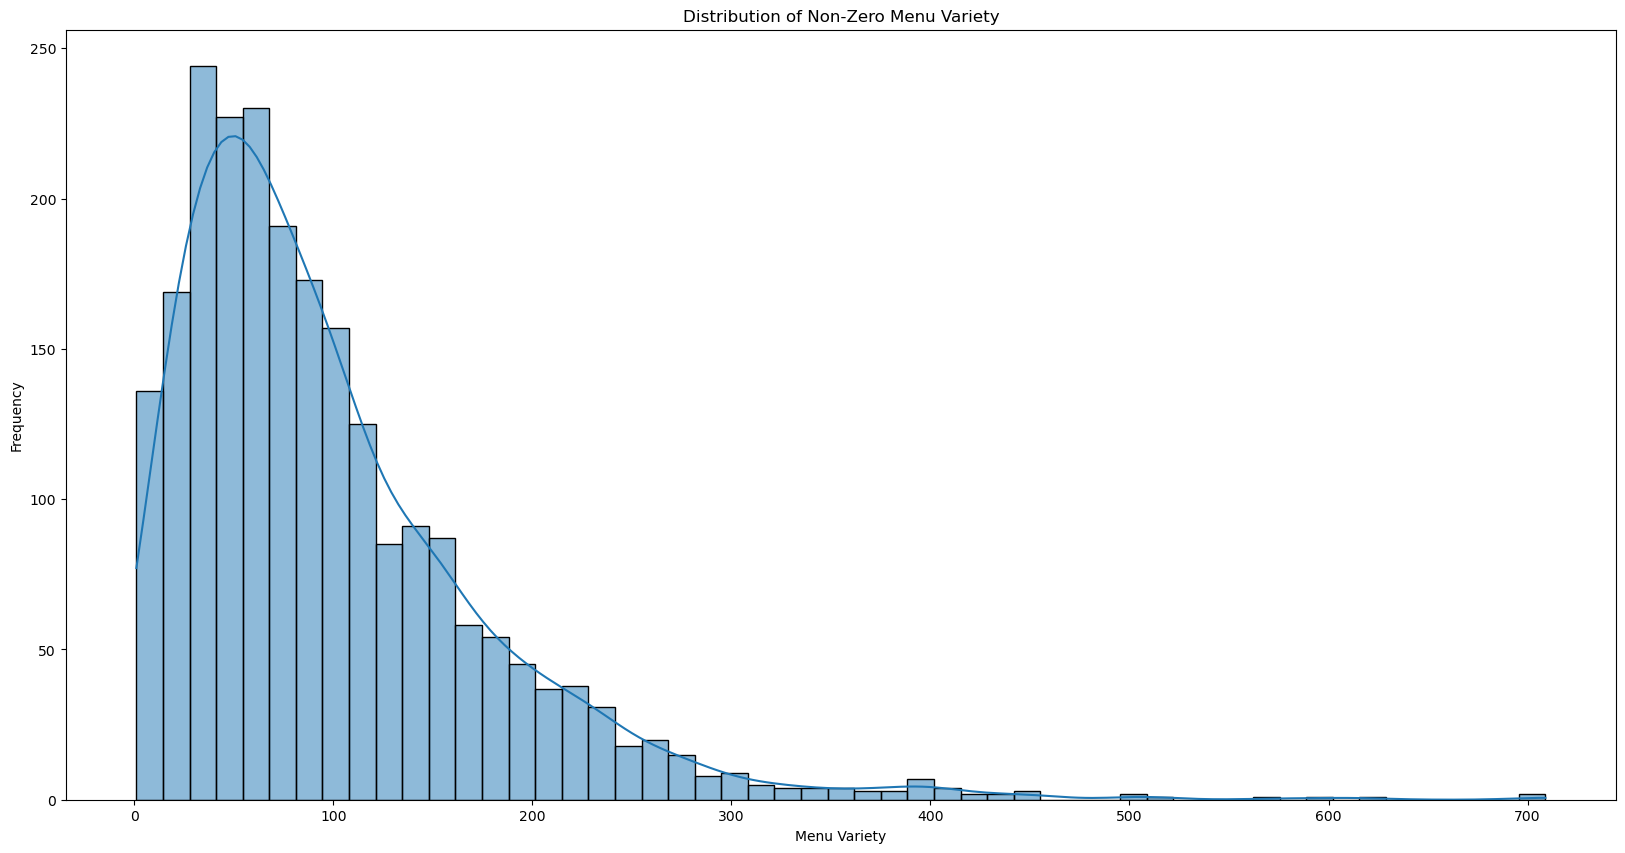

In [10]:
# Filter out non-zero values
non_zero_values = data[data["menu_variety"] != 0]["menu_variety"]

# Plot the histogram
plt.figure(figsize=(20,10))
sns.histplot(non_zero_values, kde=True)
plt.xlabel('Menu Variety')
plt.ylabel('Frequency')
plt.title('Distribution of Non-Zero Menu Variety')
plt.show()

- Given the high prevalence of zeros as only `2297` of `12457` only are non zeros in our dataset, it's better to go only with a binary indicator, `has_menu`, which simply indicates whether a restaurant offers a menu or not. This approach mitigates potential negative impacts on our model by simplifying the feature and avoiding issues associated with skewed distributions of zero values.
- consequently therefore `has_menu` will be treated in the  categorical features section.

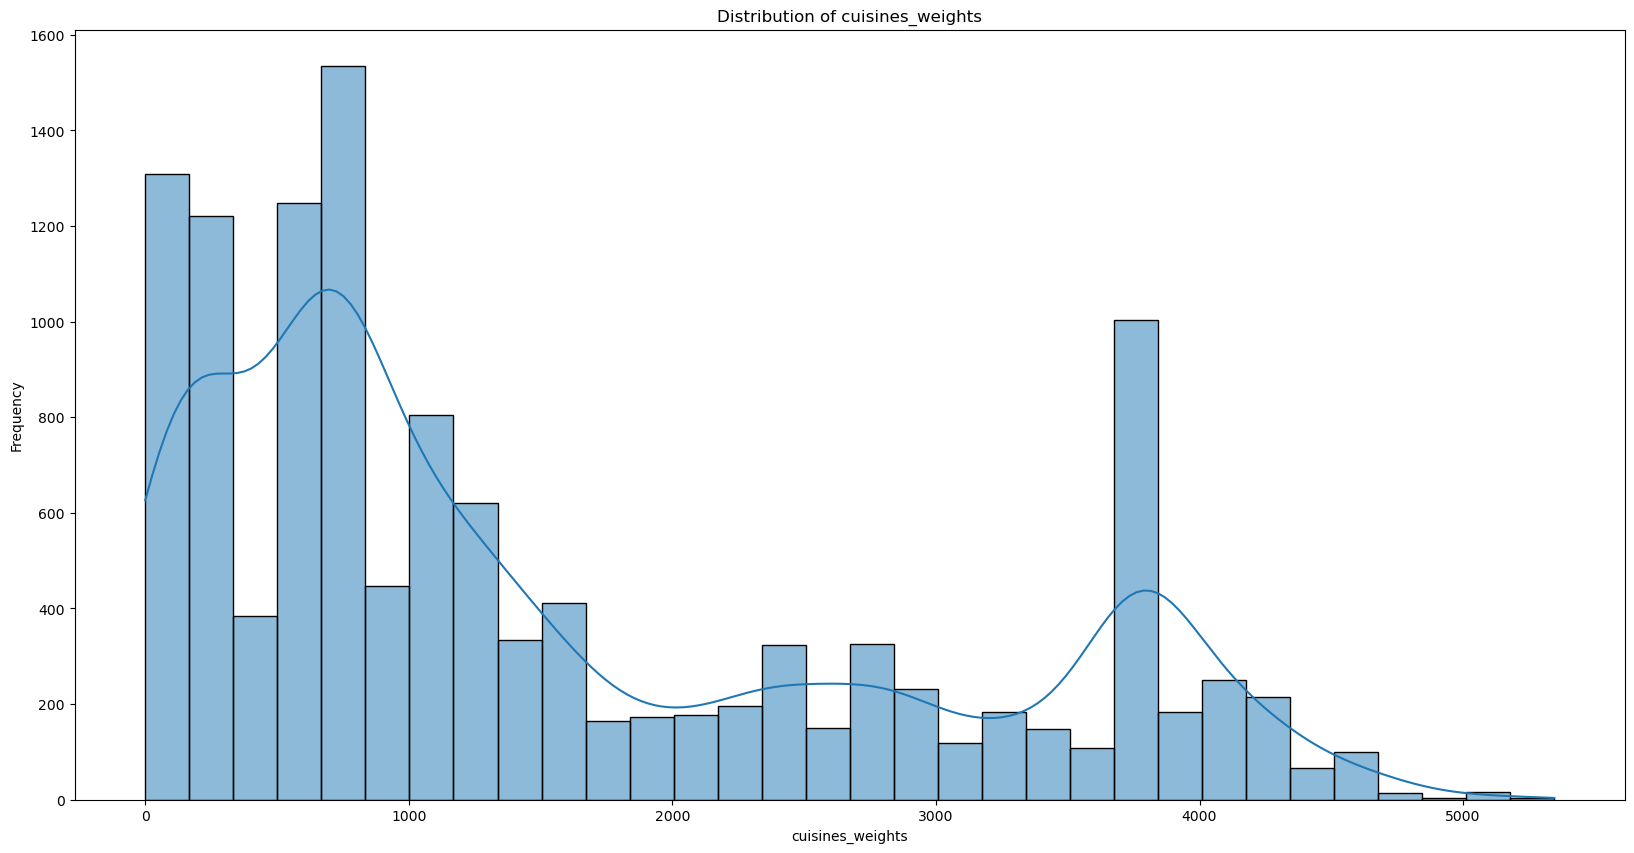

In [11]:
plt.figure(figsize=(20,10))
sns.histplot(data["cuisines_weights"], kde=True)
plt.xlabel('cuisines_weights')
plt.ylabel('Frequency')
plt.title('Distribution of cuisines_weights')
plt.show()

In [12]:
data["cuisines_weights"].describe()

count    12457.000000
mean      1526.869391
std       1339.772681
min          0.000000
25%        555.000000
50%       1036.000000
75%       2511.000000
max       5346.000000
Name: cuisines_weights, dtype: float64

 Since the range of values varies widely (from 0 to 16542) filling the nul values with the mode might be the approbraite chose.

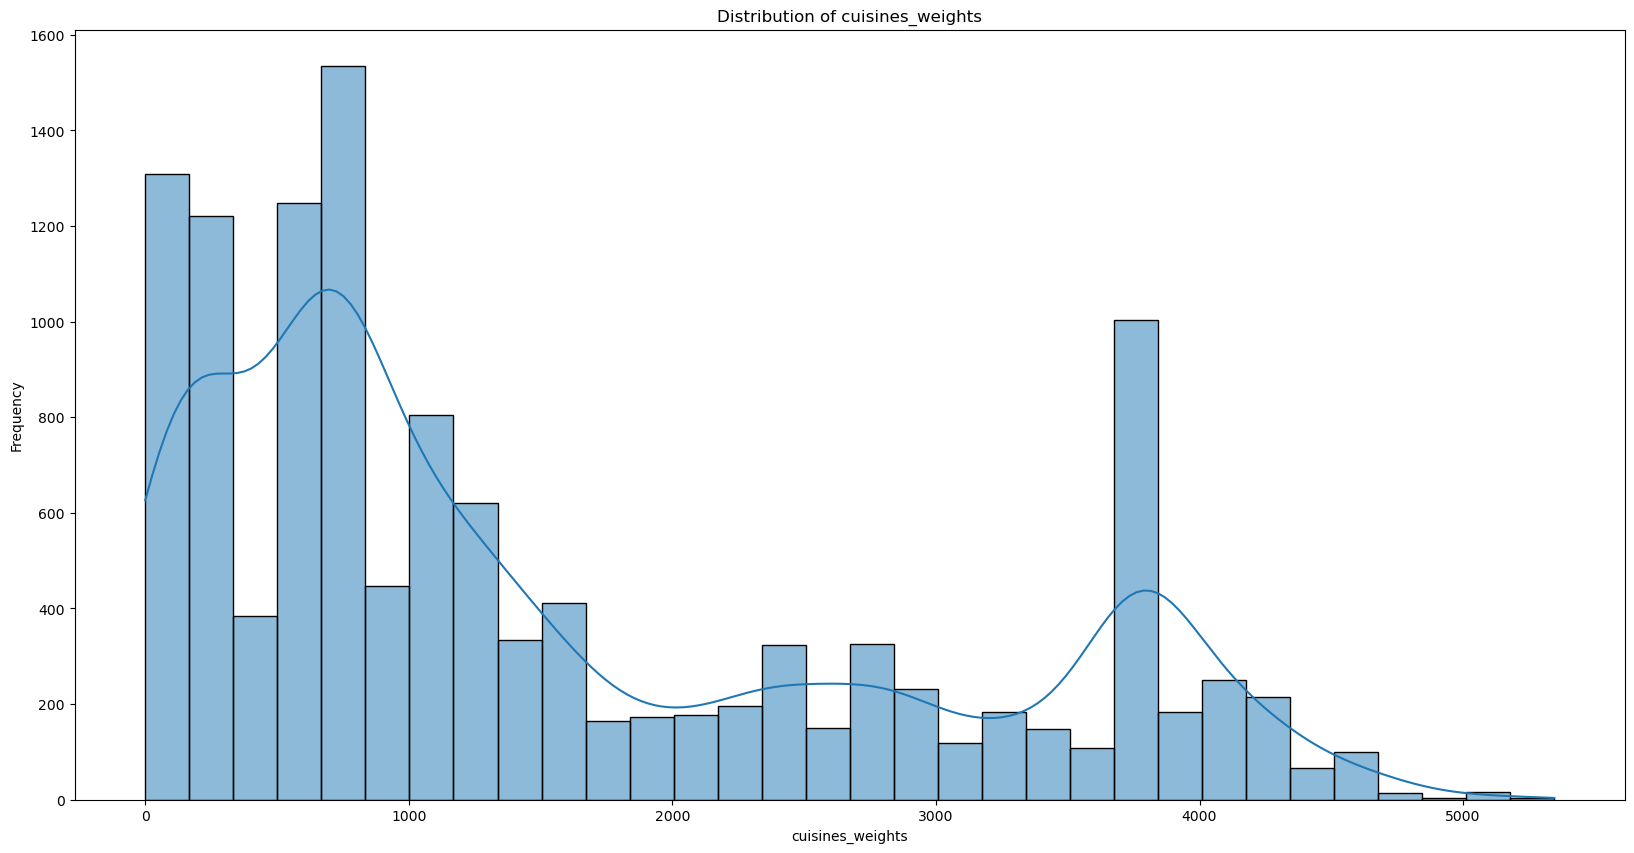

In [13]:
plt.figure(figsize=(20,10))
sns.histplot(data["cuisines_weights"], kde=True)
plt.xlabel('cuisines_weights')
plt.ylabel('Frequency')
plt.title('Distribution of cuisines_weights')
plt.show()

In [14]:

# Calculate the mean of the first quartile range
first_quartile_mean = data['cuisines_weights'][data['cuisines_weights'] <= data['cuisines_weights'].quantile(0.25)].mean()

# Replace values within the first quartile range with the mean
data.loc[data['cuisines_weights'] <= data['cuisines_weights'].quantile(0.25), 'cuisines_weights'] = first_quartile_mean

In [15]:
data["cuisines_weights"].describe()

count    12457.000000
mean      1526.869391
std       1337.642717
min        208.817600
25%        208.817600
50%       1036.000000
75%       2511.000000
max       5346.000000
Name: cuisines_weights, dtype: float64

In [16]:
data['has_menu'] = data['has_menu'].astype('object')

In [17]:
X_train['has_menu'] = data['has_menu'].astype('object')
X_test['has_menu'] = data['has_menu'].astype('object')

In [18]:
data['has_menu']

0        0
1        0
2        0
3        1
4        1
        ..
12452    0
12453    1
12454    0
12455    0
12456    0
Name: has_menu, Length: 12457, dtype: object

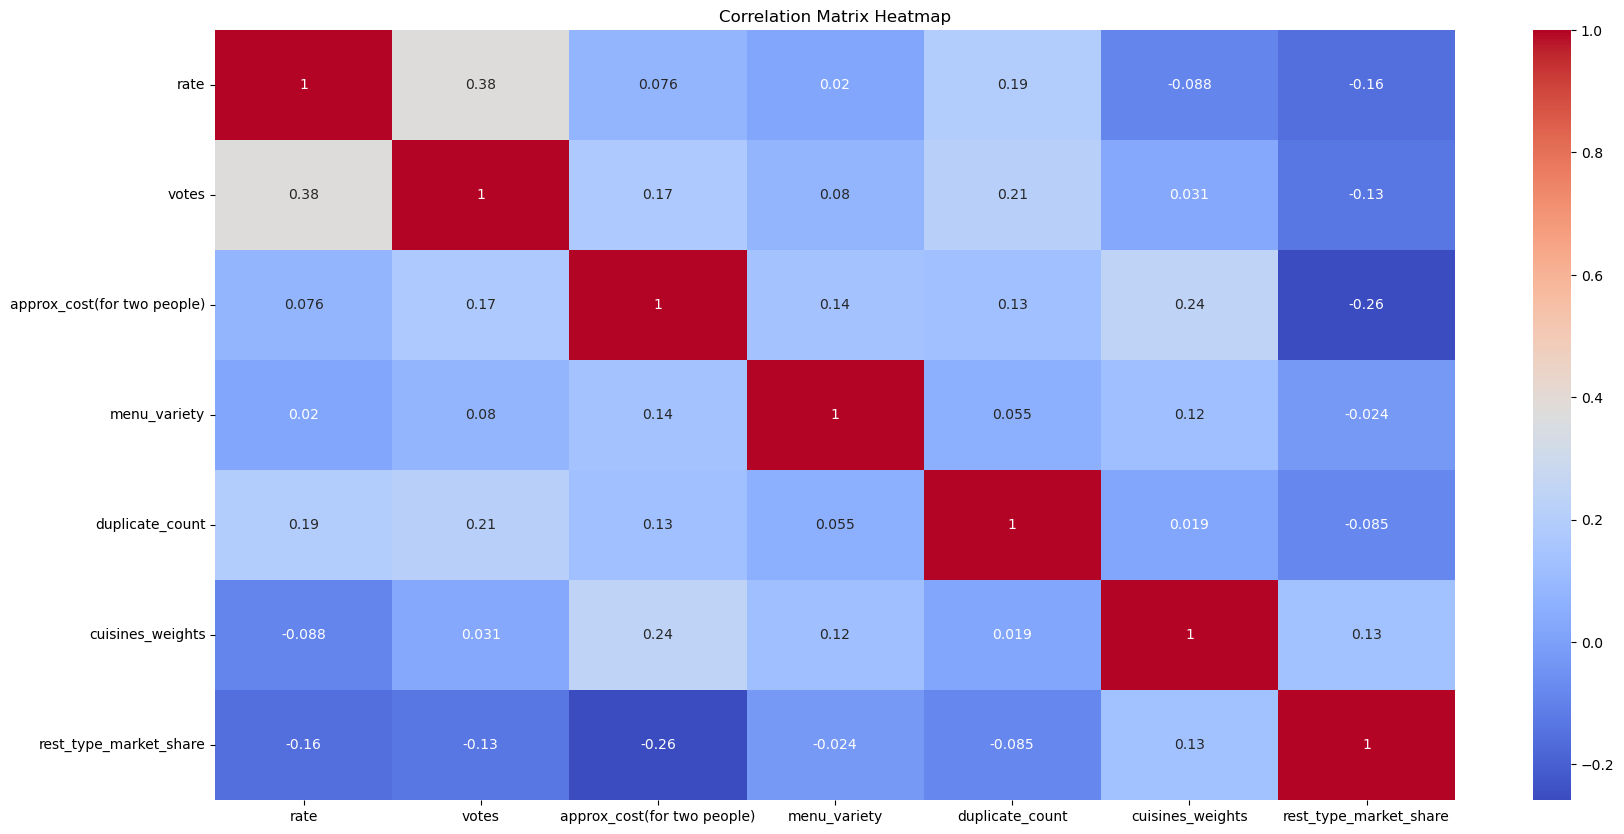

In [19]:
# Correlation matrix heatmap
def correlation_heatmap(data, target_variable):
    corr_matrix = data.corr()
    plt.figure(figsize=(20, 10))
    sns.heatmap(corr_matrix,annot=True, cmap='coolwarm')
    plt.title('Correlation Matrix Heatmap')
    plt.show()
        
        
correlation_heatmap(data[numeric_features_1], y_train)

---

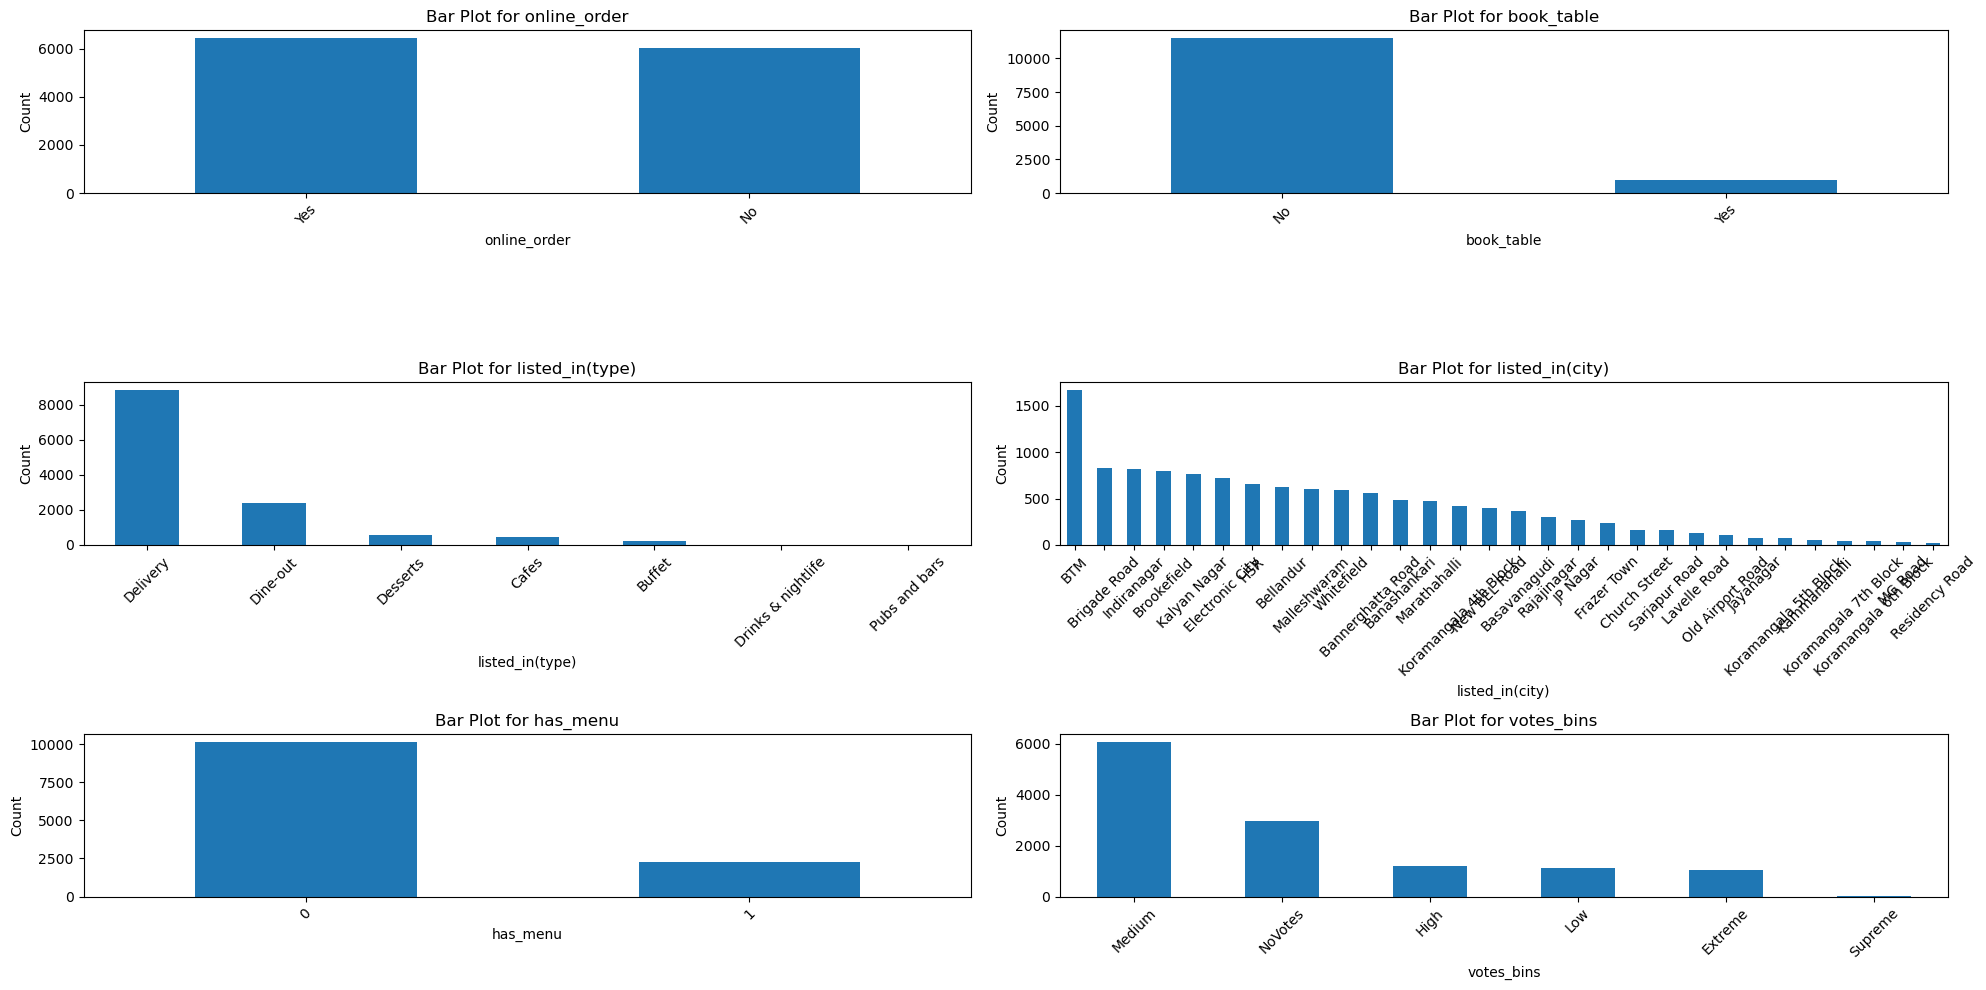

In [20]:
# Calculate the number of rows and columns for subplots
categorical_features_1 = data.select_dtypes('object').columns
num_plots = len(categorical_features_1)
num_cols = 2  # Number of columns for subplots
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate number of rows needed

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))  # Adjust the figure size as needed

# Flatten the axes array if necessary
if num_plots > 1:
    axes = axes.flatten()

# Iterate over each category and create a bar plot
for i, category in enumerate(categorical_features_1):
    # Count the occurrences of each category value
    category_counts = data[category].value_counts()
    
    # Create a bar plot
    category_counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Bar Plot for {category}')
    axes[i].set_xlabel(category)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

----

In [21]:
# Define transformations for numerical and categorical columns
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns

categorical_features = X_train.select_dtypes(include=['object']).columns

class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.log1p(X)

numeric_log_transformer = Pipeline(steps=[
    ('log_transformer', LogTransformer())
])

numeric_log_min_max_transformer = Pipeline(steps=[
    ('log_transformer', LogTransformer()),
    ('minmax_scaler', MinMaxScaler())
])

numeric_min_max_transformer = Pipeline(steps=[
    ('minmax_scaler', MinMaxScaler())
])

numeric_standard_scale_transformer = Pipeline(steps=[
    ('standard_scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])




# Combine transformations for numerical and categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num_approx_cost', numeric_min_max_transformer, ['approx_cost(for two people)']),
        ('menu_variety', numeric_log_min_max_transformer, ['menu_variety']),
        ('duplicate_count', numeric_min_max_transformer, ['duplicate_count']),
        ('num_votes', numeric_log_transformer, ['votes']),
        ('rest_type_market_share', numeric_standard_scale_transformer, ['rest_type_market_share']),
        ('cuisines_weights', numeric_standard_scale_transformer, ['cuisines_weights']),
        ('cat', categorical_transformer, categorical_features)]
)

preprocessor_target = ColumnTransformer(
    transformers=[
        ('num_rate', numeric_standard_scale_transformer, ['rate'])
])


# Apply preprocessing to training data
X_train_processed = preprocessor.fit_transform(X_train)


# Convert sparse matrix to DataFrame
X_train_processed_df = pd.DataFrame.sparse.from_spmatrix(
    X_train_processed,
    columns=numeric_features.tolist() + 
            preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
)

# Apply preprocessing to validation and test data
X_test_processed = preprocessor.transform(X_test)

# Convert sparse matrices to DataFrames
X_test_processed_df = pd.DataFrame.sparse.from_spmatrix(
    X_test_processed,
    columns=X_train_processed_df.columns
)


In [22]:
# Example preprocessing for target variable
def preprocess_target(y_train, y_test=None):
    # Convert y_train to a NumPy array
    y_train_array = np.array(y_train)
    
    # Standardize the target variable (if numeric)
    scaler = MinMaxScaler()
    y_train_scaled = scaler.fit_transform(y_train_array.reshape(-1, 1)).flatten()
    
    if y_test is not None:
        # Convert y_test to a NumPy array
        y_test_array = np.array(y_test)
        
        # Standardize y_test using the same scaler fitted on y_train
        y_test_scaled = scaler.transform(y_test_array.reshape(-1, 1)).flatten()
        return y_train_scaled, y_test_scaled
    else:
        return y_train_scaled

y_train_processed, y_test_processed = preprocess_target(y_train, y_test)


In [23]:
X_train_processed_df

,votes,approx_cost(for two people),menu_variety,duplicate_count,cuisines_weights,rest_type_market_share,online_order_No,online_order_Yes,book_table_No,book_table_Yes,...,listed_in(city)_Sarjapur Road,listed_in(city)_Whitefield,has_menu_0,has_menu_1,votes_bins_Extreme,votes_bins_High,votes_bins_Low,votes_bins_Medium,votes_bins_NoVotes,votes_bins_Supreme
0,0.395604,0.000000,0.212121,3.912023,1.153074,0.618135,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.413879,0.000000,0.060606,5.468060,-1.210391,-1.102254,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.615385,0.000000,0.000000,7.222566,-0.183589,-0.172900,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.175824,0.000000,0.030303,0.000000,1.153074,0.946362,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.395604,0.628632,0.030303,3.198673,1.153074,-0.560941,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,0.505495,0.000000,0.242424,0.000000,-1.248705,0.393086,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9961,0.230769,0.000000,0.000000,1.945910,1.153074,-0.934028,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9962,0.413879,0.000000,0.272727,6.514713,-1.234816,1.030849,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9963,0.285714,0.401973,0.212121,1.791759,1.153074,-0.959449,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


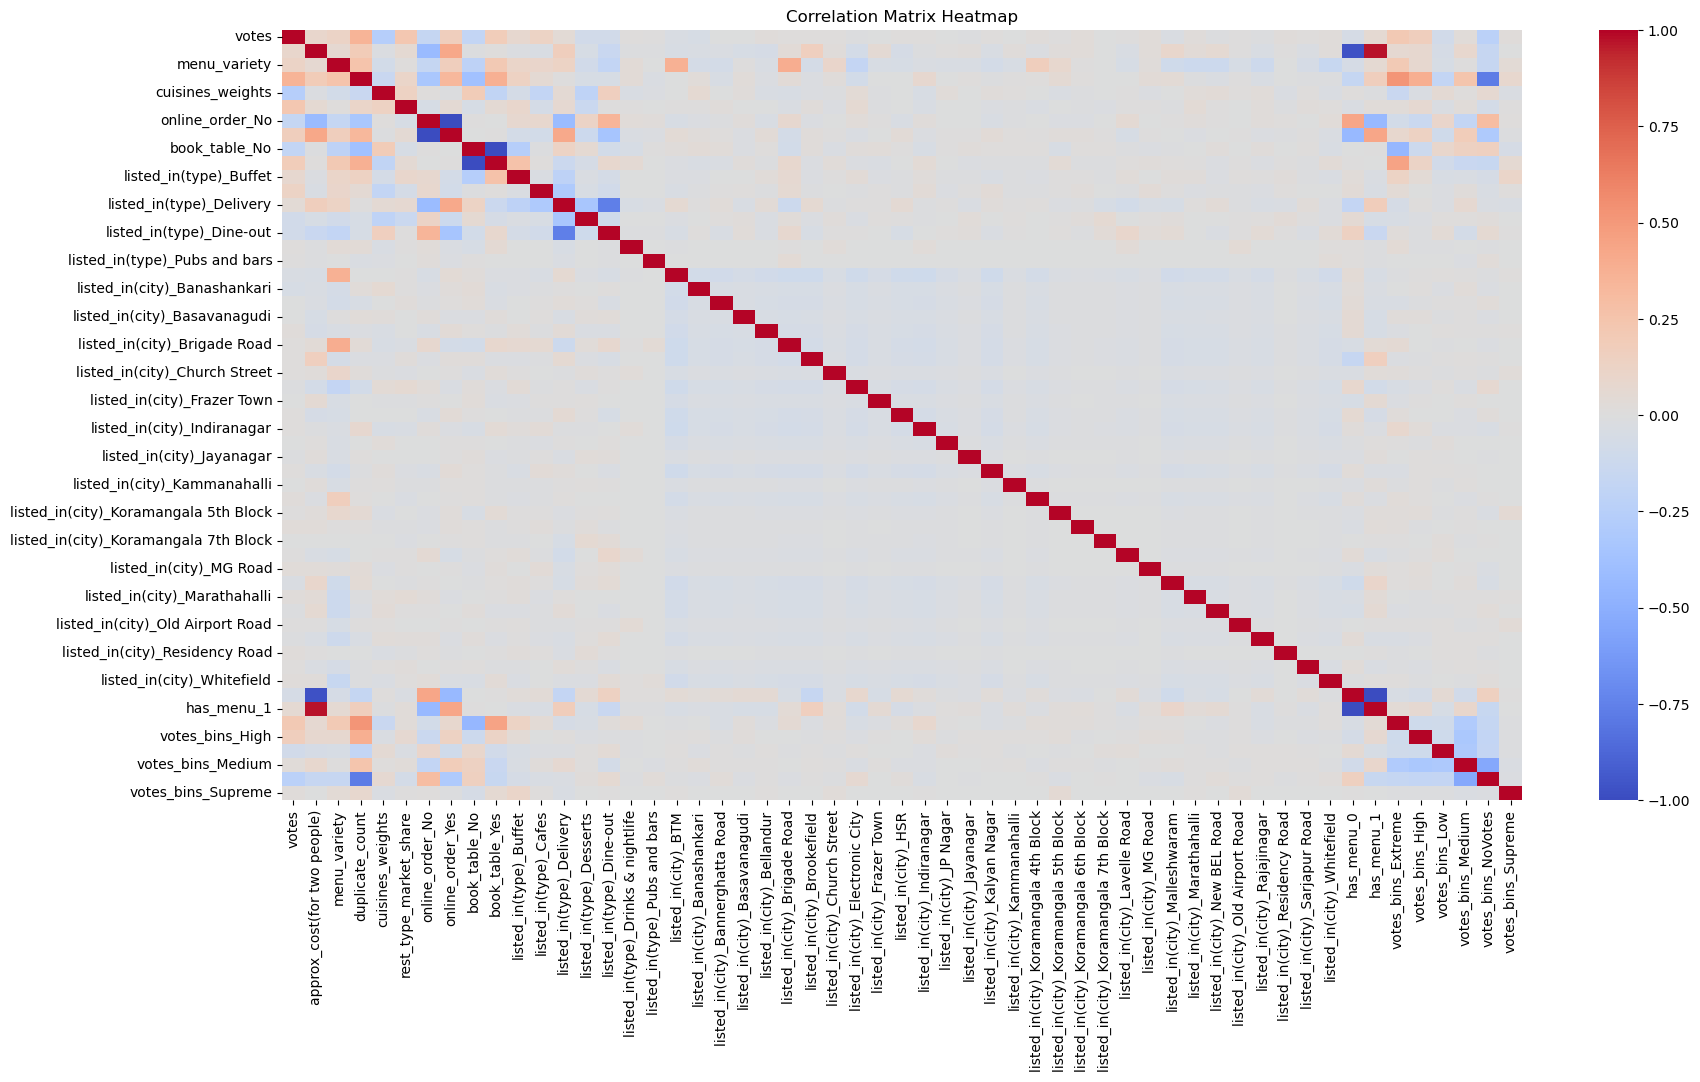

In [24]:
# Correlation matrix heatmap
def correlation_heatmap(data, target_variable):
    corr_matrix = data.corr()
    plt.figure(figsize=(20, 10))
    sns.heatmap(corr_matrix,cmap='coolwarm')
    plt.title('Correlation Matrix Heatmap')
    plt.show()
        
        
correlation_heatmap(X_train_processed_df, y_train_processed)

----

# PCA

In [27]:
# Convert DataFrame to numpy array
X_train_dense = X_train_processed_df.values

# Perform PCA
pca = PCA()
pca.fit_transform(X_train_dense)

array([[ 8.26613701e-01,  1.30390490e+00, -4.89666921e-01, ...,
         3.60391450e-15,  3.12001530e-16, -2.00714041e-17],
       [ 2.31600384e+00, -1.70653527e+00, -4.24347072e-02, ...,
        -2.39712650e-16, -8.27164496e-15,  2.51509625e-16],
       [ 4.07598755e+00, -2.12431606e-01, -3.60180087e-01, ...,
         2.08530854e-17, -2.32454322e-15, -1.56877915e-16],
       ...,
       [ 3.37620923e+00, -1.96027761e-01,  1.32363082e+00, ...,
        -1.29308525e-16,  3.14368042e-16, -1.72891769e-17],
       [-1.32171552e+00,  1.97430428e-01, -1.42108011e+00, ...,
        -5.62587479e-17,  7.13386290e-17, -3.09067512e-16],
       [ 4.27677137e+00,  1.19479855e+00,  1.02159106e+00, ...,
         2.94417367e-17,  2.48288836e-17, -1.72632259e-16]])

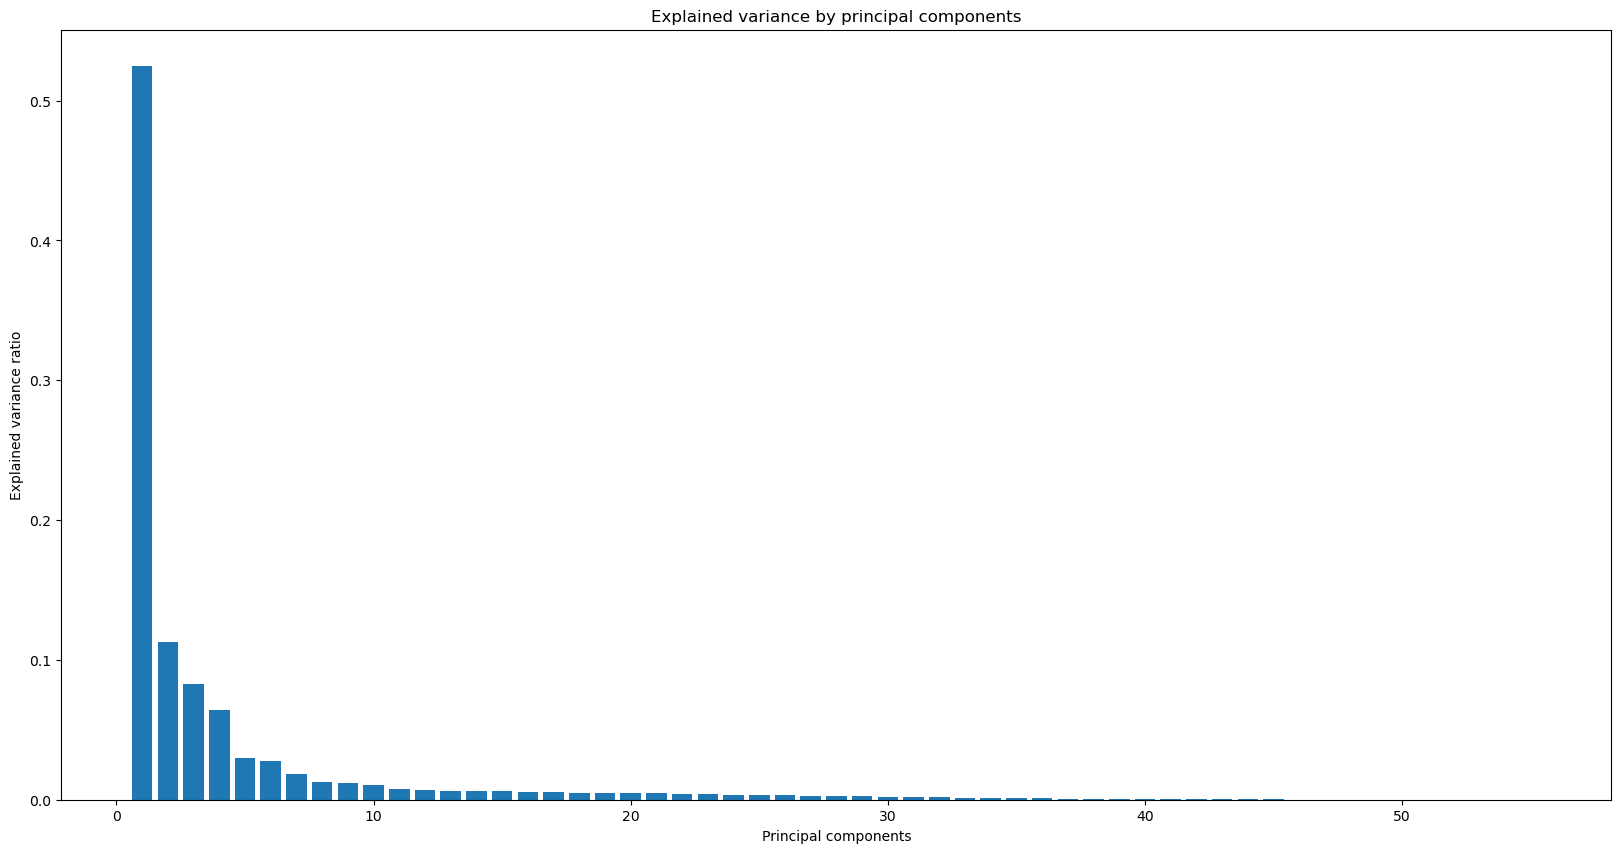

In [28]:
plt.figure(figsize = (20,10))
# Explained variance by principal components
var_exp = pca.explained_variance_ratio_
components = range(1, len(var_exp) + 1)
# Visualize explained variance
plt.bar(components, var_exp)
plt.title('Explained variance by principal components')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio')
plt.show()

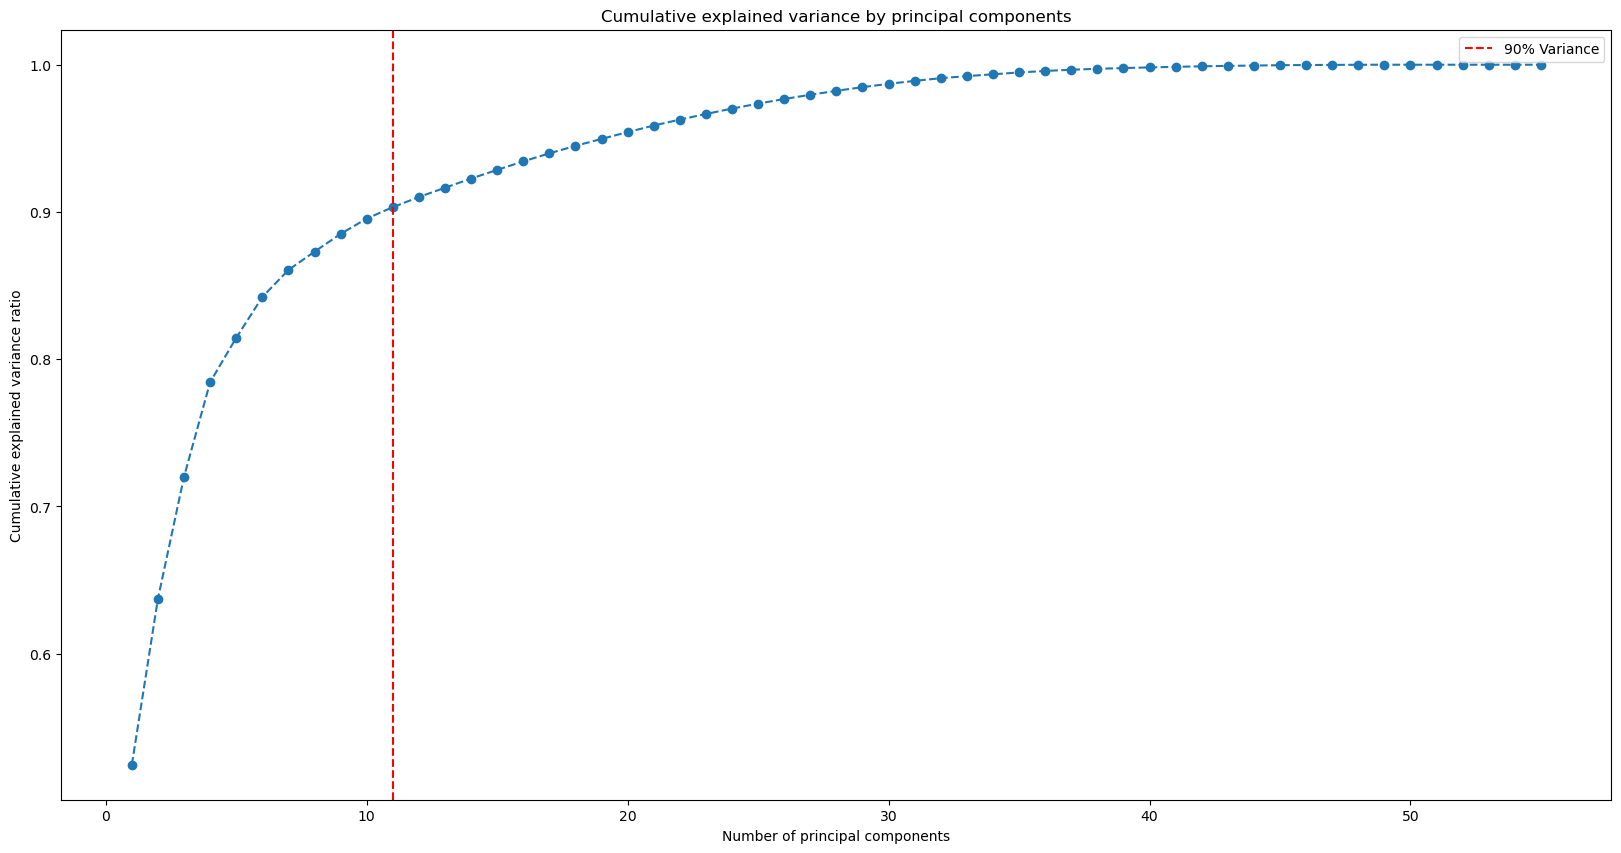

In [29]:
# Calculate cumulative explained variance
cumulative_var_exp = np.cumsum(var_exp)
# Find the number of principal components that represent 90% of the variance
n_components_90 = np.argmax(cumulative_var_exp >= 0.90) + 1
# Plot cumulative explained variance ratio
plt.figure(figsize = (20,10))
plt.plot(components, cumulative_var_exp, marker='o', linestyle='--')
plt.title('Cumulative explained variance by principal components')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance ratio')
plt.axvline(x=n_components_90, color='r', linestyle='--', label='90% Variance')
plt.legend()
plt.show()

In [30]:
# Determining the numper of Principle components that capture `90`% of the variance in our data set
pca = PCA(n_components=n_components_90)

In [31]:
X_train_dense_reduced = pca.fit_transform(X_train_dense)

# Convert DataFrame to numpy array
X_test_dense = X_test_processed_df.values
# Apply preprocessing to validation and test data
X_test_processed_dense_reduced = pca.transform(X_test_dense)

In [32]:
X_train_dense_reduced.shape

(9965, 11)

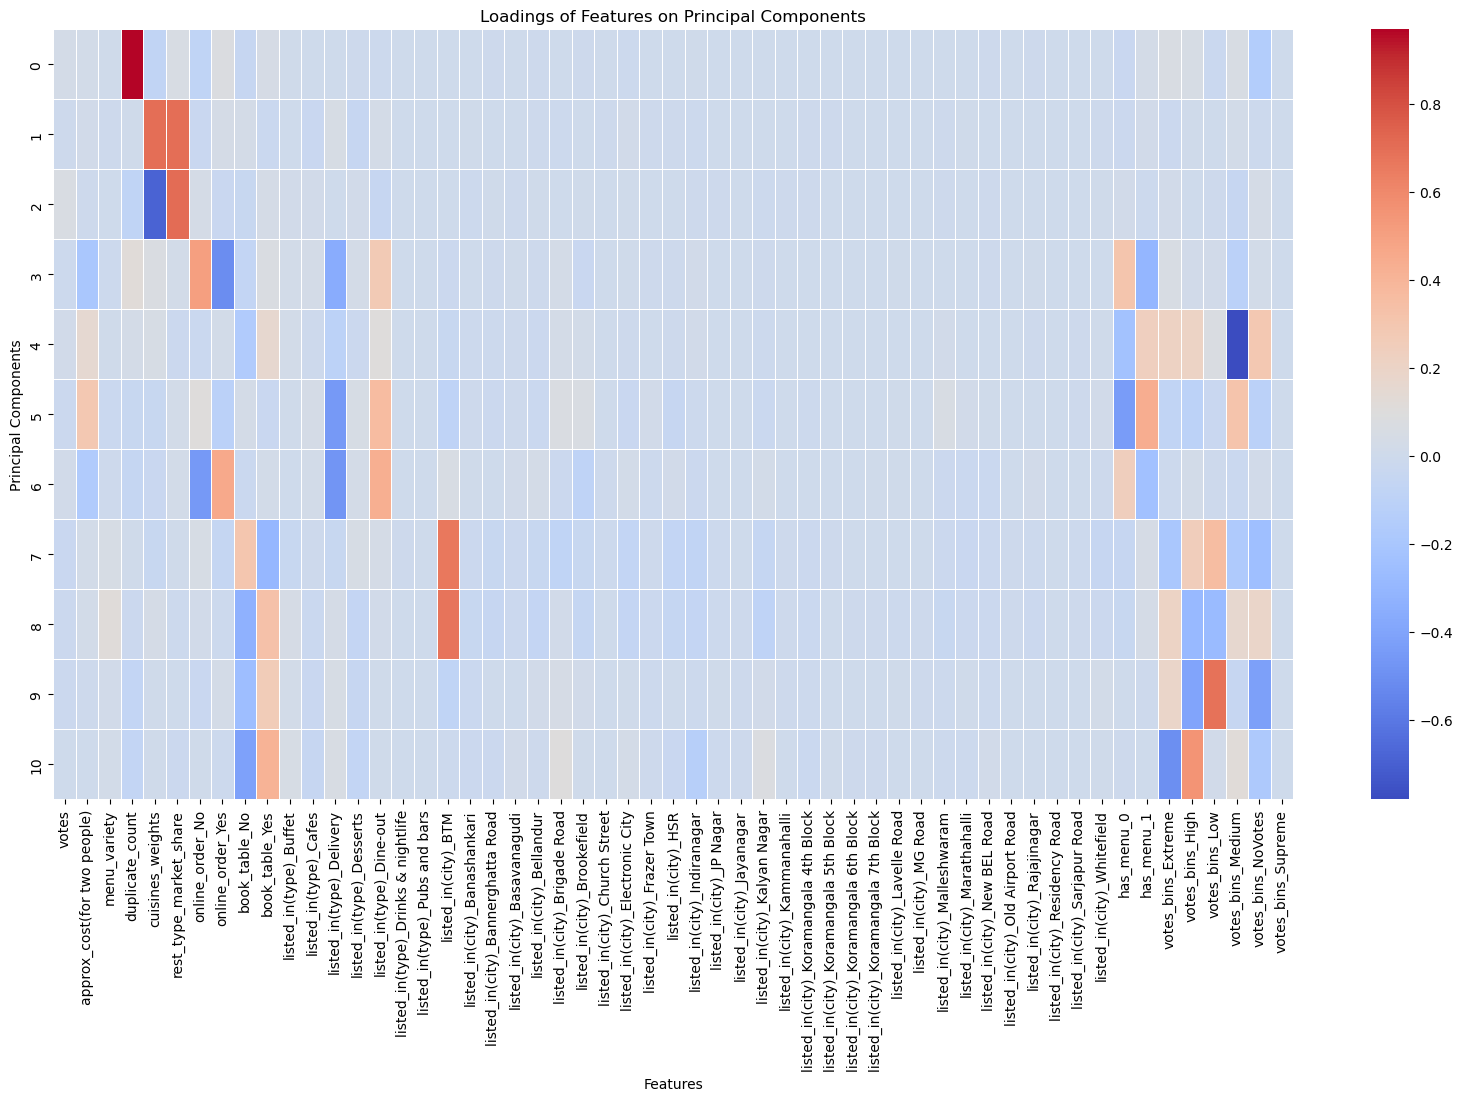

In [33]:
# Access loadings matrix
loadings = pca.components_

# Create a DataFrame to store loadings
loadings_df = pd.DataFrame(loadings, columns=X_train_processed_df.columns)

# Visualize loadings
plt.figure(figsize=(20, 10))
sns.heatmap(loadings_df, cmap='coolwarm', linewidths=0.5)
plt.title('Loadings of Features on Principal Components')
plt.xlabel('Features')
plt.ylabel('Principal Components')
plt.show()


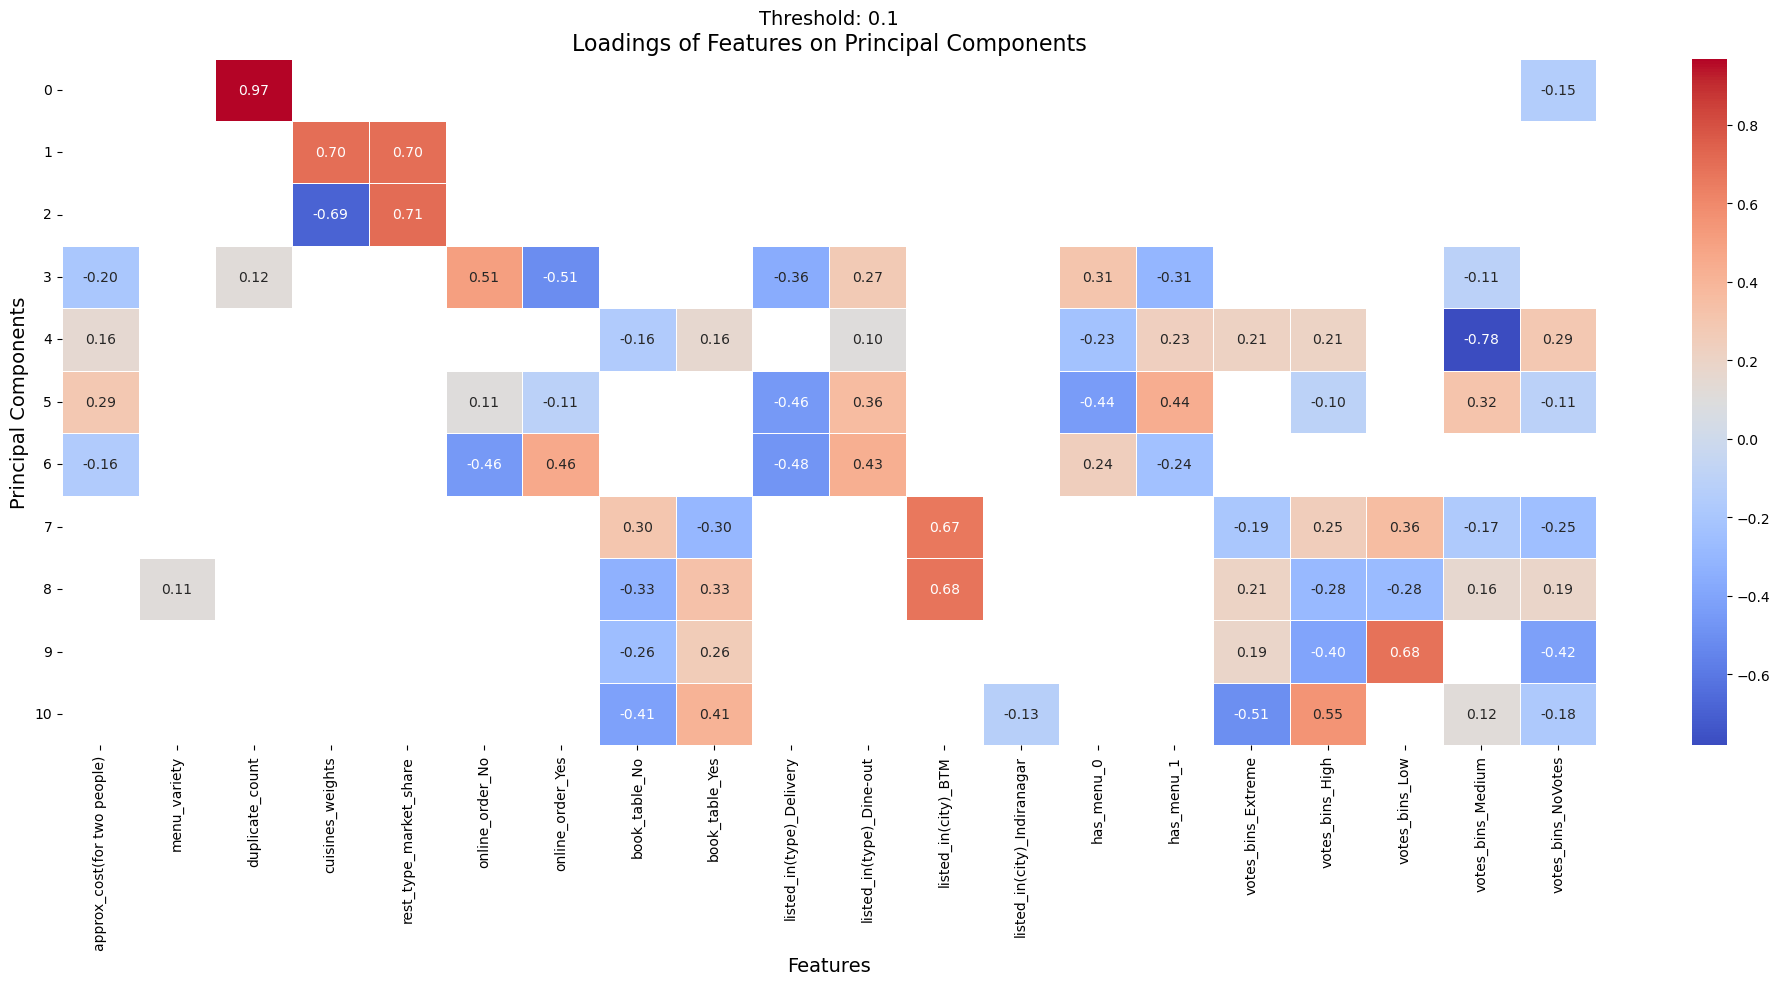

In [34]:
# Apply threshold
threshold = 0.1
thresholded_loadings_df = loadings_df.mask(np.abs(loadings_df) < threshold)

# Exclude features with all NaN values (below threshold)
thresholded_loadings_df = thresholded_loadings_df.dropna(axis=1, how='all')

# Set up heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(thresholded_loadings_df, cmap='coolwarm', linewidths=0.5, annot=True, fmt=".2f")

# Add annotation for threshold
plt.text(0.5, 1.05, f'Threshold: {threshold}', horizontalalignment='center', fontsize=14, transform=plt.gca().transAxes)

# Add titles and labels
plt.title('Loadings of Features on Principal Components', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Principal Components', fontsize=14)

# Rotate y-axis labels for better readability
plt.yticks(rotation=0)

# Show plot
plt.tight_layout()
plt.show()


### Interpreting and understanding the relationship between features and principal components. 

- **Feature Importance**: Features with higher absolute loadings (closer to 1 or -1) on a principal component contribute more to that component's variance. These features are important in explaining the underlying structure of the data.

- **Feature Grouping**: Look for clusters or groups of features that have similar loadings on a principal component. These groups of features may represent underlying patterns or relationships in the data.




----

# Modeling

In this pahse based on our data profilinig and data characteristics and feature understanding and our assumptions that we have validated we first determin on a:
- Baseline Model: Choose a simple, interpretable model for comparison.
- Candidate Models: Select models based on problem type, data, and goals.
- Train, Validate, Refine: Train models, evaluate, adjust hyperparameters, and iterate.
- Final Evaluation & Selection: Choose the best model based on test set performance and project needs.

In [35]:
Linear_regression = LinearRegression()
Linear_regression.fit(X_train_dense_reduced, y_train)
score_1 = Linear_regression.score(X_train_dense_reduced,y_train)
print("Linear regression scored on train: ", score_1)

score_2 = Linear_regression.score(X_test_processed_dense_reduced,y_test)
print("Linear regression scored on test: ", score_2)

Linear regression scored on train:  0.35954627021339003
Linear regression scored on test:  0.32454623062559906


In [36]:
# Instantiate the Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_regressor.fit(X_train_processed_df, y_train)

# Evaluate the model's performance on the training set
rf_score_1 = rf_regressor.score(X_train_processed_df, y_train)
print("Random Forest Regressor scored on train: ", rf_score_1)

# Evaluate the model's performance on the test set
rf_score_2 = rf_regressor.score(X_test_processed_df, y_test)
print("Random Forest Regressor scored on test: ", rf_score_2)


Random Forest Regressor scored on train:  0.9169294281819237
Random Forest Regressor scored on test:  0.38620090334401047


In [37]:
# Instantiate the Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation on the training data
cv_scores = cross_val_score(rf_regressor, X_train_processed_df, y_train, cv=5, scoring='r2')

# Fit the model to the entire training data for reporting purposes
rf_regressor.fit(X_train_processed_df, y_train)

# Evaluate the model's performance using cross-validation
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

# Evaluate the model's performance on the test set
rf_score = rf_regressor.score(X_test_processed_df, y_test)
print("Random Forest Regressor scored on test: ", rf_score)


Cross-Validation Scores: [0.41847308 0.37298309 0.40451877 0.40172118 0.4163494 ]
Mean CV Score: 0.4028091027684601
Random Forest Regressor scored on test:  0.38620090334401047


In [38]:
# Evaluate the model's performance on the test set using cross-validation
test_cv_scores = cross_val_score(rf_regressor, X_test_processed_df, y_test, cv=5, scoring='r2')
print("Cross-Validation Scores on Test Set:", test_cv_scores)
print("Mean CV Score on Test Set:", test_cv_scores.mean())

Cross-Validation Scores on Test Set: [0.31279547 0.30484211 0.43477073 0.30480183 0.36005275]
Mean CV Score on Test Set: 0.34345257777503174


In [39]:
# Instantiate the Random Forest Regressor model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_regressor.fit(X_train_dense_reduced, y_train)

# Evaluate the model's performance on the training set
rf_score_train = rf_regressor.score(X_train_dense_reduced, y_train)
print("Random Forest Regressor scored on train: ", rf_score_train)

# Evaluate the model's performance on the test set
rf_score_test = rf_regressor.score(X_test_processed_dense_reduced, y_test)
print("Random Forest Regressor scored on test: ", rf_score_test)

# Use cross-validation to get a more reliable estimate of performance
cv_scores = cross_val_score(rf_regressor, X_train_dense_reduced, y_train, cv=5)
print("Cross-validated scores:", cv_scores)
print("Mean CV score:", np.mean(cv_scores))

# Perform feature selection
selector = SelectFromModel(estimator=rf_regressor, threshold=-np.inf, max_features=10)
selector.fit(X_train_dense_reduced, y_train)
X_train_selected = selector.transform(X_train_dense_reduced)
X_test_selected = selector.transform(X_test_processed_dense_reduced)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_selected, y_train)
best_params = grid_search.best_params_
print("Best parameters found:", best_params)

# Use the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
best_model_score_test = best_model.score(X_test_selected, y_test)
print("Best model scored on test:", best_model_score_test)


Random Forest Regressor scored on train:  0.9108168952325286
Random Forest Regressor scored on test:  0.33905271624019695
Cross-validated scores: [0.38064684 0.33329211 0.37818809 0.34757803 0.372642  ]
Mean CV score: 0.36246941601915345
Best parameters found: {'max_depth': 7, 'n_estimators': 300}
Best model scored on test: 0.3655459770326428


#### Given the initial poor data correlation, our modeling process was inherently limited by the predictive power of our dataset.
#### Despite exhaustive exploration of various algorithms (I imported for you above), the effectiveness of our models remained constrained. 
#### Ultimately, the choice of a capable model mattered less than the inherent limitations of our data.

> # As the project concludes, I encourage you to revisit the initial phase (Problem Statement) where we discussed Other Potential Areas for Exploration and explore them independently.

## Grateful for your time going through this kernel! 🙌🔍 Any feedback or improvements are welcome!